# Granite-TimeSeries-TTM   

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import TimeSeriesForecastingPipeline, TimeSeriesPreprocessor, TinyTimeMixerForPrediction
from tsfm_public.toolkit.time_series_preprocessor import get_datasets, prepare_data_splits
from tsfm_public.toolkit.visualization import plot_predictions


set_seed(42)

In [2]:
import tsfm_public


tsfm_public.__version__

'0.2.9.dev6+gc65d87f'

## Initial setup
1. Download energy_data.csv.zip and weather_data.csv.zip from https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
2. Place the downloaded files into a folder and update the data_path below

In [3]:
data_path = pathlib.Path("./data")

In [4]:
def compute_metric(actual, prediction):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    mask = ~np.any(np.isnan(a), axis=1)  # ~np.isnan(a)
    p = np.asarray(prediction.tolist())
    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    return {"mean_squared_error": mse, "root_mean_squared_error": np.sqrt(mse)}

## Load and prepare data

In [5]:
dataset_path = data_path / "energy_dataset.csv.zip"

timestamp_column = "time"

id_columns = []
control_columns = []

control_columns = [
    "temp",
    "temp_min",
    "temp_max",
    "pressure",
    "wind_speed",
    "wind_deg",
    "humidity",
    "rain_1h",
    "rain_3h",
    "clouds_all",
]

target_columns = ["total load actual"]

context_length = 512
prediction_length = 96

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

data = data.ffill()  # data.mean())

data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [6]:
exog_path = data_path / "weather_features.csv.zip"
exog_timestamp_column = "dt_iso"
exog_data = pd.read_csv(
    exog_path,
    parse_dates=[exog_timestamp_column],
)
# exog_data[exog_timestamp_column] = pd.to_datetime(exog_data[exog_timestamp_column], utc=True)


keep_cols = [
    c for c in exog_data.columns if c not in ["weather_id", "weather_main", "weather_description", "weather_icon"]
]
exog_data = exog_data[keep_cols]

# aggregate
value_cols = [c for c in keep_cols if c not in ["dt_iso", "city_name"]]
exog_data = exog_data.groupby("dt_iso")[value_cols].median()


data = data.merge(exog_data, left_on=timestamp_column, right_on=exog_timestamp_column)

In [7]:
data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,270.475,270.475,1035.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,270.475,270.475,1035.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,269.686,269.686,1036.0,78.0,1.0,48.0,0.0,0.0,0.0,0.0
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,269.686,269.686,1035.0,78.0,1.0,48.0,0.0,0.0,0.0,0.0
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,269.686,269.686,1035.0,78.0,1.0,48.0,0.0,0.0,0.0,0.0


## Create a TimeSeriesPreprocessor and prepare datasets

In [8]:
split_params = {"train": [0, 0.6], "valid": [0.6, 0.8], "test": [0.8, 1.0]}

params = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": control_columns,
    "context_length": 512,
    "prediction_length": 96,
}

tsp = TimeSeriesPreprocessor(
    **params,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_data, valid_data, test_data = prepare_data_splits(
    data,
    id_columns=params["id_columns"],
    context_length=params["context_length"],
    split_config=split_params,
)

dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config=split_params)

## Finetune the model to capture cross-channel correlations

The **TTM** model is huggingface compliant, supporting use of the HF trainer, as well as easy loading and saving of models. Finetuning, the **TTM** model allows capturing cross-channel interactions and the effect of exogenous channels.

### Load pretrained model
Similar to loading the zero-shot model, we load the pretrained model but specify some additional configuration.

In [9]:
set_seed(42)
finetune_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1",
    num_input_channels=tsp.num_input_channels,
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_use_mixer=True,
    fcm_context_length=10,
    enable_forecast_channel_mixing=True,
    decoder_mode="mix_channel",
)

# freeze parameters in the model backbone
for param in finetune_model.backbone.parameters():
    param.requires_grad = False

finetune_model_parameters = sum(p.numel() for p in finetune_model.parameters() if p.requires_grad)
print("TTM Model parameters:", finetune_model_parameters)

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-v1 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

TTM Model parameters: 526409


### Configure trainer

In [10]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR


lr: float = 0.0001
n_epochs: int = 200
patience: int = 2
batch_size: int = 256

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=patience,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.00001,  # Minimum improvement required to consider as improvement
)

optimizer = AdamW(finetune_model.parameters(), lr=lr)
scheduler = OneCycleLR(
    optimizer,
    lr,
    epochs=n_epochs,
    steps_per_epoch=(len(dset_train) // batch_size) + 1,
)


check_point_directory = f"checkpoint_{os.getpid()}"

finetune_forecast_args = TrainingArguments(
    output_dir=f"{check_point_directory}",
    overwrite_output_dir=True,
    learning_rate=lr,
    num_train_epochs=n_epochs,
    do_eval=True,
    optim="adamw_hf",
    # lr_scheduler_type="constant",
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=4,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="fewshot_logs",
    # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    use_cpu=True,  # remove if GPU is available
    max_steps=10,  # only for a quick test
)

trainer = Trainer(
    model=finetune_model,
    args=finetune_forecast_args,
    train_dataset=dset_train,
    eval_dataset=dset_valid,
    # ptimizers=(optimizer, scheduler),
    callbacks=[early_stopping_callback],
)

max_steps is given, it will override any value given in num_train_epochs


### Run the finetuning

In [11]:
trainer.train()

/Users/wmgifford/miniconda3/envs/tsfm_public/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:p-13633:t-8325308672:config.py:<module>:PyTorch version 2.3.0 available.
INFO:p-13635:t-8325308672:config.py:<module>:PyTorch version 2.3.0 available.
INFO:p-13642:t-8325308672:config.py:<module>:PyTorch version 2.3.0 available.
INFO:p-13643:t-8325308672:config.py:<module>:PyTorch version 2.3.0 available.


{'loss': 0.5168, 'grad_norm': 1.0507687330245972, 'learning_rate': 0.0, 'epoch': 0.12}


INFO:p-13806:t-8325308672:config.py:<module>:PyTorch version 2.3.0 available.
INFO:p-13808:t-8325308672:config.py:<module>:PyTorch version 2.3.0 available.
INFO:p-13809:t-8325308672:config.py:<module>:PyTorch version 2.3.0 available.
INFO:p-13810:t-8325308672:config.py:<module>:PyTorch version 2.3.0 available.


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.4670465886592865, 'eval_runtime': 46.4146, 'eval_samples_per_second': 149.048, 'eval_steps_per_second': 0.603, 'epoch': 0.12}
{'train_runtime': 103.0114, 'train_samples_per_second': 24.852, 'train_steps_per_second': 0.097, 'train_loss': 0.516758394241333, 'epoch': 0.12}


TrainOutput(global_step=10, training_loss=0.516758394241333, metrics={'train_runtime': 103.0114, 'train_samples_per_second': 24.852, 'train_steps_per_second': 0.097, 'total_flos': 90140230287360.0, 'train_loss': 0.516758394241333, 'epoch': 0.125})

### Create a time series forecasting pipeline and generate forecasts

In [12]:
finetuned_pipeline = TimeSeriesForecastingPipeline(
    finetune_model,
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=target_columns,
    control_columns=control_columns,
    batch_size=2000,
    feature_extractor=tsp,
)
finetune_forecast = finetuned_pipeline(tsp.preprocess(test_data))
finetune_forecast.head()

,time,total load actual_prediction,total load actual
0,2018-03-14 18:00:00+01:00,"[30833.796190832585, 31865.53531922398, 31738....","[35043.99973664599, 36229.999787301436, 35065...."
1,2018-03-14 19:00:00+01:00,"[31711.85213283868, 31891.046317789136, 30495....","[36229.999787301436, 35065.000150100284, 32327..."
2,2018-03-14 20:00:00+01:00,"[31189.889128732888, 30119.22072541759, 28005....","[35065.000150100284, 32327.999963904855, 29527..."
3,2018-03-14 21:00:00+01:00,"[28955.97878771756, 27475.377388188197, 25659....","[32327.999963904855, 29527.999966038646, 27513..."
4,2018-03-14 22:00:00+01:00,"[25636.469258307443, 24769.729918523673, 23580...","[29527.999966038646, 27513.00002212207, 25726...."


## Evaluate results

In [13]:
metrics = {
    "FineTune": compute_metric(
        finetune_forecast["total load actual"], finetune_forecast["total load actual_prediction"]
    ),
}
pd.DataFrame(metrics)

,FineTune
mean_squared_error,9.235396e+06
root_mean_squared_error,3.038979e+03


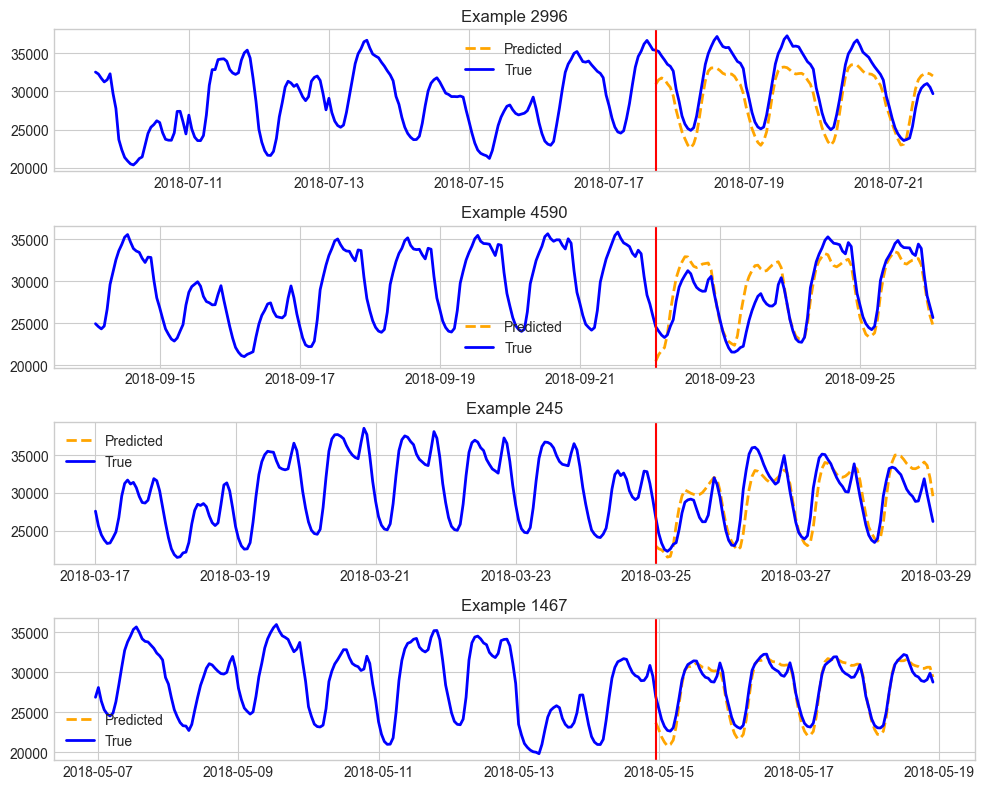

In [14]:
plot_predictions(
    test_df=test_data,
    predictions_df=finetune_forecast,
    timestamp_column=timestamp_column,
    freq=tsp.freq,
    plot_dir=None,
    plot_prefix="Test",
    channel="total load actual",
    plot_context=2 * prediction_length,
    # indices = [5352, 4964, 1451, 6691],
    num_plots=4,
)

## Useful links

TinyTimeMixer paper: https://arxiv.org/abs/2401.03955  

Granite-TimeSeries-TTM model: https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1  

Publicly available tools for working with our models: https://github.com/ibm-granite/granite-tsfm

© 2024 IBM Corporation